<a href="https://colab.research.google.com/github/AltagiAbdallah/Movie-Recommendation-Predictive-Analytics-Engine/blob/main/Recommender_Systems_(Movies).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **PROJECT:** *Movie Recommender System*
>> **PIPELINE:** load → filter → pivot (user×movie) → cosine (item–item) → recommend → visualize
- EVAL: Surprise SVD + KNNBasic with RMSE/MAE on train/test split
>> NOTES:
- Cosine sim is on item vectors (columns), so we transpose the matrix.



>> **Connect Colab to Google Drive**

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


>> **Import libraries**

In [3]:
!pip install surprise

In [4]:
!pip install "numpy<2"

In [15]:
## Imports

import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
from surprise import KNNBasic
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [17]:
# Load the Dataset

movies = pd.read_csv('/content/drive/MyDrive/new /movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/new /ratings.csv')

print("Movies Shape:", movies.shape)
print("Ratings Shape:", ratings.shape)
print(movies.head())
print(ratings.head())


Movies Shape: (9742, 3)
Ratings Shape: (100836, 4)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


**PHASE 1 : Load Data**

In [6]:
# Load the Dataset

movies = pd.read_csv('/content/drive/MyDrive/new /movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/new /ratings.csv')

print("Movies Shape:", movies.shape)
print("Ratings Shape:", ratings.shape)
print(movies.head())
print(ratings.head())


Movies Shape: (9742, 3)
Ratings Shape: (100836, 4)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


**PHASE 2 : Merge and Create User-Item Matrix**

In [7]:
## Merge and Create User-Item Matrix
data = pd.merge(ratings, movies, on='movieId')
data.head()

user_item_matrix = data.pivot_table(index='userId', columns='title', values='rating')
user_item_matrix.fillna(0, inplace=True)
user_item_matrix.head()


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**PHASE 3 : Cosine Similarity**

In [8]:
## Cosine Similarity

similarity_matrix = cosine_similarity(user_item_matrix.T)
similarity_df = pd.DataFrame(similarity_matrix,
                             index=user_item_matrix.columns,
                             columns=user_item_matrix.columns)
similarity_df.iloc[:5, :5]


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997)
title,,,,,
'71 (2014),1.0,0.000000,0.000000,0.000000,0.000000
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.000000,0.000000
'Round Midnight (1986),0.0,0.707107,1.000000,0.000000,0.000000
'Salem's Lot (2004),0.0,0.000000,0.000000,1.000000,0.857493
'Til There Was You (1997),0.0,0.000000,0.000000,0.857493,1.000000


**PHASE 4 : Recommendation Function**

In [9]:
## Recommendation Function
def recommend_movies(movie_title, n=5):
    if movie_title not in similarity_df.columns:
        return f"Movie '{movie_title}' not found."
    similar_movies = similarity_df[movie_title].sort_values(ascending=False)
    return similar_movies.iloc[1:n+1]

recommend_movies('Toy Story (1995)', 5)


,Toy Story (1995)
title,
Toy Story 2 (1999),0.572601
Jurassic Park (1993),0.565637
Independence Day (a.k.a. ID4) (1996),0.564262
Star Wars: Episode IV - A New Hope (1977),0.557388
Forrest Gump (1994),0.547096


**PHASE 5 : Visualization**

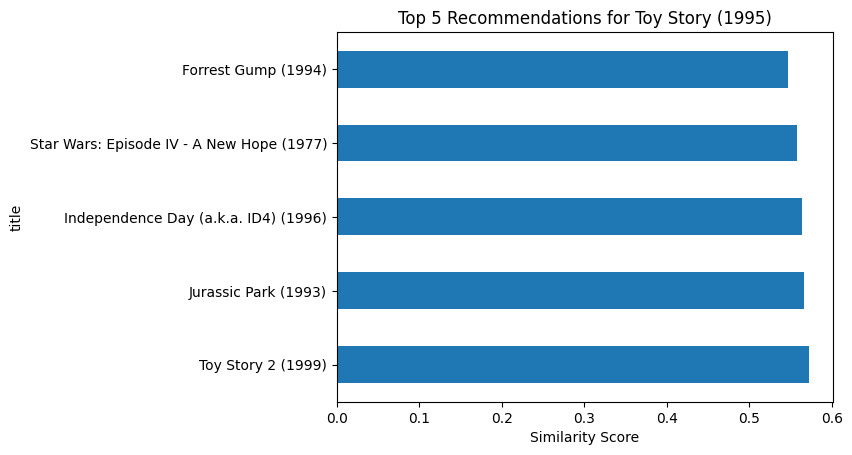

In [10]:
## Visualization
recs = recommend_movies('Toy Story (1995)', 5)
recs.plot(kind='barh', title="Top 5 Recommendations for Toy Story (1995)")
plt.xlabel("Similarity Score")
plt.show()


**PHASE 6 : Try with Another Movie**

In [11]:
## Try with Another Movie
recommend_movies('Jumanji (1995)', 5)


,Jumanji (1995)
title,
"Lion King, The (1994)",0.588438
Mrs. Doubtfire (1993),0.549818
"Mask, The (1994)",0.544981
Jurassic Park (1993),0.538046
Home Alone (1990),0.524876


**PHASE 7: Rating Distribution Histogram**

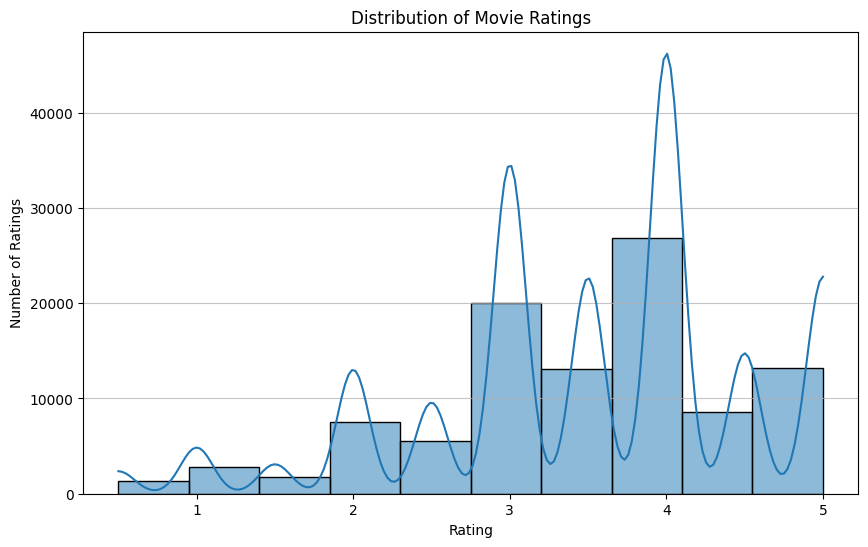

In [19]:

plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.grid(axis='y', alpha=0.75)
plt.show()

**PHASE 8 : SVD (Surprise)**

In [12]:
## SVD (Surprise) — Train/Test + RMSE/MAE


# WHY SVD: learns latent factors (user/movie embeddings) → predicts ratings on unseen pairs
# Split = 80/20 for honest evaluation (no leakage); Surprise handles ID remapping internally.
# RMSE vs MAE: RMSE penalizes big errors more; MAE is robust to outliers. Lower = better.



df_r = ratings_f if 'ratings_f' in globals() else ratings
rmin, rmax = float(df_r['rating'].min()), float(df_r['rating'].max())
if rmin == rmax: rmin, rmax = 0.0, 5.0

reader = Reader(rating_scale=(rmin, rmax))
data = Dataset.load_from_df(df_r[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd = SVD(random_state=42)
svd.fit(trainset)
preds_svd = svd.test(testset)
print("SVD performance:")
rmse(preds_svd, verbose=True)
mae(preds_svd, verbose=True)


SVD performance:
RMSE: 0.8807
MAE:  0.6766


0.6765729095860605

**PHASE 9 : KNNBasic (User-Based)**

In [20]:
## PHASE 8 : KNNBasic (User-Based) — Train/Test + RMSE/MAE


# WHY user-based KNN: "users who rate similarly tend to rate items alike"
# sim_options={'cosine','user_based':True} → cosine between user rows; neighbor set size affects bias/variance.
# Cold-start: if a user/item unseen → fall back to global/user mean (Surprise handles gracefully).



sim_options = {'name': 'cosine', 'user_based': True}
knn_user = KNNBasic(sim_options=sim_options)
knn_user.fit(trainset)
preds_knn = knn_user.test(testset)
print("KNNBasic (user-based) performance:")
rmse(preds_knn, verbose=True)
mae(preds_knn, verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic (user-based) performance:
RMSE: 0.9823
MAE:  0.7559


0.7558972904135215